# Stack-Overflow Annual Developer Survey Analyis


Within this Analysis I analyze what influences Salary within developer jobs. <br>
The goal is to develop a model that could potentially *help employees estimate their worth* and *employers plan their expense* in a market that is sometimes intransparent in regards to salary. <br>
Analysis is based on the `annual developer survey by stackoverflow:` <https://survey.stackoverflow.co/>

In [43]:
# Import all packages needed
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import shap
import category_encoders as ce



In [2]:
# Load survey schema

schema = pd.read_csv('data/survey_results_schema.csv')
schema.head()

,qid,qname,question,force_resp,type,selector
0,QID2,MainBranch,Which of the following options best describes ...,True,MC,SAVR
1,QID127,Age,What is your age?*,True,MC,SAVR
2,QID296,Employment,Which of the following best describes your cur...,True,MC,MAVR
3,QID308,RemoteWork,Which best describes your current work situation?,False,MC,SAVR
4,QID341,Check,Just checking to make sure you are paying atte...,True,MC,SAVR


In [3]:
# Load data

df_raw = pd.read_csv('data/survey_results_public.csv')
df_raw.head()

,ResponseId,MainBranch,Age,Employment,RemoteWork,Check,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,...,JobSatPoints_6,JobSatPoints_7,JobSatPoints_8,JobSatPoints_9,JobSatPoints_10,JobSatPoints_11,SurveyLength,SurveyEase,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,Under 18 years old,"Employed, full-time",Remote,Apples,Hobby,Primary/elementary school,Books / Physical media,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,I am a developer by profession,35-44 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,3,I am a developer by profession,45-54 years old,"Employed, full-time",Remote,Apples,Hobby;Contribute to open-source projects;Other...,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Books / Physical media;Colleague;On the job tr...,Technical documentation;Blogs;Books;Written Tu...,...,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN,NaN
3,4,I am learning to code,18-24 years old,"Student, full-time",NaN,Apples,NaN,Some college/university study without earning ...,"Other online resources (e.g., videos, blogs, f...",Stack Overflow;How-to videos;Interactive tutorial,...,NaN,NaN,NaN,NaN,NaN,NaN,Too long,Easy,NaN,NaN
4,5,I am a developer by profession,18-24 years old,"Student, full-time",NaN,Apples,NaN,"Secondary school (e.g. American high school, G...","Other online resources (e.g., videos, blogs, f...",Technical documentation;Blogs;Written Tutorial...,...,NaN,NaN,NaN,NaN,NaN,NaN,Too short,Easy,NaN,NaN


----------------------------

--------------------

## 1. Exploratory Data Analysis

Check the PDF of the Survey that comes with the data for a detailed understanding of the survey and its questions (i.e. potential features and targets).

#### Check the target = Salary
`ConvertedCompYearly`

In [4]:
df_eda = df_raw.copy()

In [5]:
# some simple descriptive statistics
print(f'Rows without salary information {df_eda.ConvertedCompYearly.isna().sum()}')
df_eda.ConvertedCompYearly.describe()

Rows without salary information 42002


count    2.343500e+04
mean     8.615529e+04
std      1.867570e+05
min      1.000000e+00
25%      3.271200e+04
50%      6.500000e+04
75%      1.079715e+05
max      1.625660e+07
Name: ConvertedCompYearly, dtype: float64

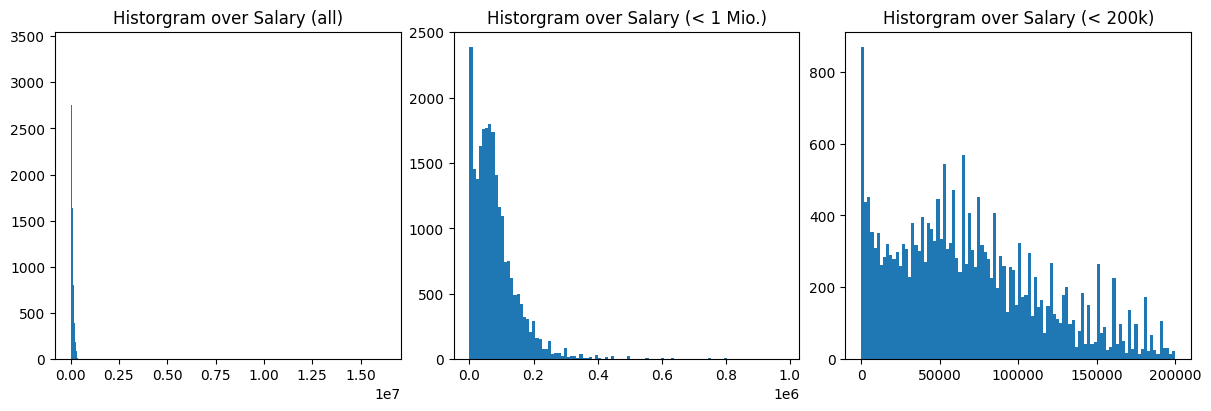

In [6]:
# Check distribution of salary

fig, axs = plt.subplots(1, 3, layout='constrained', figsize=(12, 4))
axs[0].hist(df_eda.ConvertedCompYearly, bins = 1000) 
axs[0].set_title('Historgram over Salary (all)')
axs[1].hist(df_eda.ConvertedCompYearly[df_eda.ConvertedCompYearly < 1000000], bins = 100) 
axs[1].set_title('Historgram over Salary (< 1 Mio.)')
axs[2].hist(df_eda.ConvertedCompYearly[df_eda.ConvertedCompYearly < 200000], bins = 100) 
axs[2].set_title('Historgram over Salary (< 200k)')

plt.show()

*Issues*  to consider:
- Just a little more than 1/3 of the participants gave a salary.
- Salary extremly skewed (potentially influential outliers)
- A lot of participants gave unrealistically small salary (~ 0)


In [7]:
# Exploring Features only on rows with salary!
df_eda = df_eda[df_eda.ConvertedCompYearly.notna()]
df_eda.shape

(23435, 114)

In [8]:
print(df_eda[df_eda.ConvertedCompYearly < 500].ConvertedCompYearly.value_counts())
# salary < 500$ seems unrealistic for a full time job even in low income countries --> exclude
# extremly high salaries might have high impect and be influential in leafs
df_eda = df_eda[(df_eda['ConvertedCompYearly'] > 500) & (df_eda['ConvertedCompYearly'] <= 200000)]
df_eda.shape

ConvertedCompYearly
1.0      16
494.0     6
148.0     6
3.0       5
296.0     5
         ..
485.0     1
452.0     1
319.0     1
271.0     1
63.0      1
Name: count, Length: 191, dtype: int64


(21782, 114)

------------------------------------------------------------------------------------------------------------------------------

#### Potential features examination

To keep the model relatively simple, interpretable and usable for prediction features will only include the first two sections of the survey (1. Basic Information & 2 - Education + Work + Career.) <br>
Additionally questions `BuyNewTool`, `BuildvsBuy`, `TechEndorse` will be excluded for two main reasons:
1. No logical reason why they should influence salary
2. And more importantly, not really applicable when trying to predict an appropriate salary

`Currency` will be excluded as Salary in target is converted already and besides conversion, currency mostly represents duplicate information with country.

`LearnCodeOnline` will be excluded as it is clearly secondary information to `LearnCode`.

`TechDoc` will be excluded. This might indirectly represent a devs abilities or style of work but seems like in theory it should not *directly* influence salary.


In [9]:
# make sure to only include those that passed the check of attention in survey
# --> only those who pass can continue the survey so 100% pass in data
df_eda.Check.describe()

count      21782
unique         1
top       Apples
freq       21782
Name: Check, dtype: object

##### `MainBranch` & `Emplyoment`
Technically we only care about those who work as some sort of dev professionally as we want to determine what influences salary of a dev. For comparibility we stick to full time emplyoment.

In [10]:
# filter to keep only those working as some sort of dev professionally and being employed full time
df_eda = df_eda[
    (df_eda['MainBranch'] == "I am a developer by profession") &
    (df_eda['Employment'].str.contains("Employed, full-time", na=False))
]

df_eda.shape

(17500, 114)

In [11]:
# preselection of features
df_eda = df_eda[['Age', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode', 'YearsCode', 'YearsCodePro', 'DevType', 'OrgSize',
       'PurchaseInfluence', 'Country', 'ConvertedCompYearly']]

df_eda.shape

(17500, 12)

In [12]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17500 entries, 72 to 41185
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  17500 non-null  object 
 1   RemoteWork           17498 non-null  object 
 2   CodingActivities     17497 non-null  object 
 3   EdLevel              17500 non-null  object 
 4   LearnCode            17473 non-null  object 
 5   YearsCode            17465 non-null  object 
 6   YearsCodePro         17452 non-null  object 
 7   DevType              17478 non-null  object 
 8   OrgSize              17482 non-null  object 
 9   PurchaseInfluence    17473 non-null  object 
 10  Country              17500 non-null  object 
 11  ConvertedCompYearly  17500 non-null  float64
dtypes: float64(1), object(11)
memory usage: 1.7+ MB


##### `YearsCode` & `YearsCodePro`

Apart from our target all columns (features) are of datatype object. <br>
`YearsCode` & `YearsCodePro` could technically be numerical. So lets check them:

In [13]:
df_eda.YearsCode.unique()
df_eda.YearsCode.value_counts()

YearsCode
10                    1629
8                     1177
7                     1031
6                     1011
15                     997
12                     926
5                      860
20                     828
9                      810
14                     711
4                      632
11                     617
13                     559
25                     503
16                     495
18                     452
17                     396
30                     378
3                      373
24                     273
22                     263
40                     218
19                     214
23                     194
21                     186
26                     179
35                     173
2                      171
27                     142
28                     138
32                      94
38                      84
29                      81
34                      81
42                      68
33                      66
45                

In [14]:
df_eda.YearsCodePro.value_counts()

YearsCodePro
3                   1560
2                   1382
5                   1379
4                   1256
6                   1179
10                  1129
8                   1041
7                   1001
12                   668
1                    662
9                    615
15                   539
11                   519
13                   423
20                   416
Less than 1 year     386
14                   383
16                   323
17                   293
18                   277
25                   272
19                   184
24                   163
23                   154
22                   149
30                   145
26                   140
21                   114
28                   110
27                   101
35                    62
32                    54
29                    53
40                    47
34                    41
38                    37
33                    33
31                    32
37                    26
36          

We can clearly see that the format of the question allowed for or explictly offered answers that cannot be converted to float or integer. <br>
These values make up only a fraction of the dataset but represent edge cases (<1 year and > 50 years). 

We have the option to exclude these values and convert the rest to integer or replace these values with an adequate integer. <br>
To ensure that the model applies to people with very little or very much coding experience as well I am going to keep the edge cases and convert them to the next integer (i.e. < 1year &rarr; 0 and >50 &rarr; 51). <br>
Furthermore I am going to treat years as continious variables.

In [15]:
# replace values

df_eda.replace(
    {'More than 50 years': '51', 'Less than 1 year': '0'}, inplace=True
)

# convert to int

# Convert the two columns to integers
df_eda['YearsCode'] = pd.to_numeric(df_eda['YearsCode'], errors='coerce').fillna(0).astype(int)
df_eda['YearsCodePro'] = pd.to_numeric(df_eda['YearsCodePro'], errors='coerce').fillna(0).astype(int)

# check if it worked
df_eda.info()

print(df_eda.YearsCode.value_counts())
 
print(df_eda.YearsCodePro.value_counts())

<class 'pandas.core.frame.DataFrame'>
Index: 17500 entries, 72 to 41185
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  17500 non-null  object 
 1   RemoteWork           17498 non-null  object 
 2   CodingActivities     17497 non-null  object 
 3   EdLevel              17500 non-null  object 
 4   LearnCode            17473 non-null  object 
 5   YearsCode            17500 non-null  int64  
 6   YearsCodePro         17500 non-null  int64  
 7   DevType              17478 non-null  object 
 8   OrgSize              17482 non-null  object 
 9   PurchaseInfluence    17473 non-null  object 
 10  Country              17500 non-null  object 
 11  ConvertedCompYearly  17500 non-null  float64
dtypes: float64(1), int64(2), object(9)
memory usage: 1.7+ MB
YearsCode
10    1629
8     1177
7     1031
6     1011
15     997
12     926
5      860
20     828
9      810
14     711
4      632
11

array([[<Axes: xlabel='YearsCode', ylabel='YearsCode'>,
        <Axes: xlabel='YearsCodePro', ylabel='YearsCode'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='YearsCode'>],
       [<Axes: xlabel='YearsCode', ylabel='YearsCodePro'>,
        <Axes: xlabel='YearsCodePro', ylabel='YearsCodePro'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='YearsCodePro'>],
       [<Axes: xlabel='YearsCode', ylabel='ConvertedCompYearly'>,
        <Axes: xlabel='YearsCodePro', ylabel='ConvertedCompYearly'>,
        <Axes: xlabel='ConvertedCompYearly', ylabel='ConvertedCompYearly'>]],
      dtype=object)

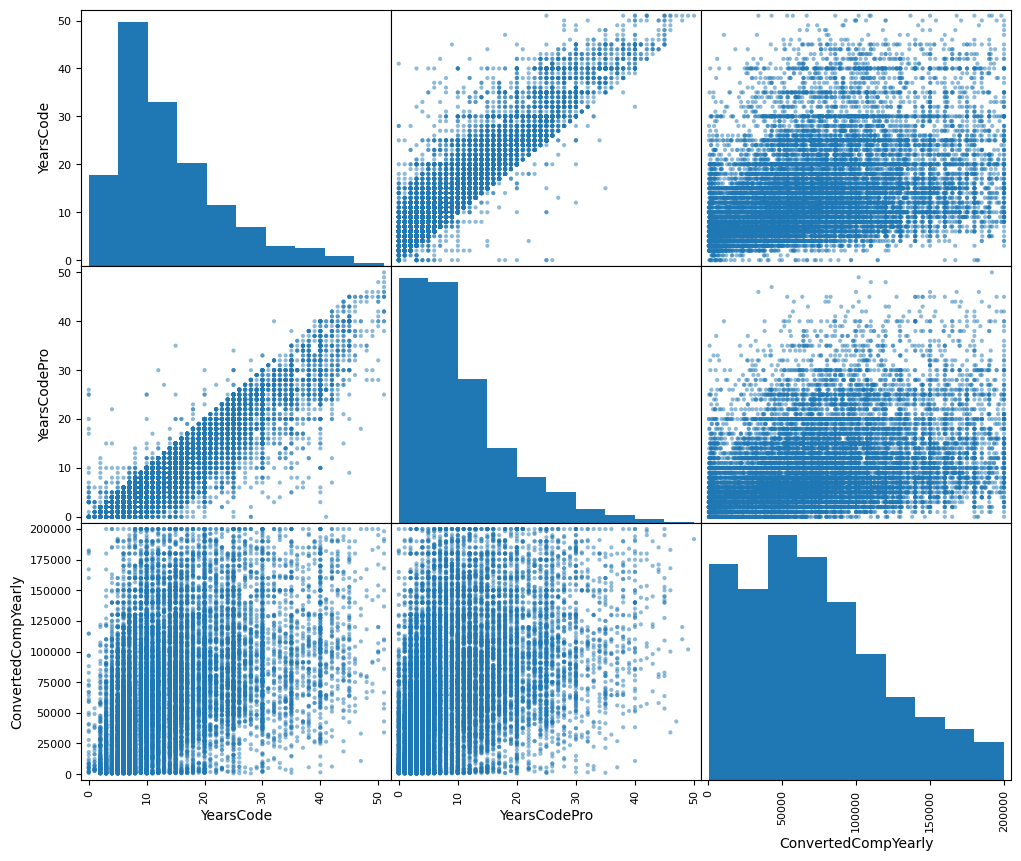

In [16]:
scatter_matrix(df_eda[['YearsCode', 'YearsCodePro', 'ConvertedCompYearly']], figsize=(12, 10))

We can see that both `YearsCode` and `YearsCodePro`have a right skewed distribution. <br>

These two variables are clearly correlated &rarr; potentially colinearity <br>

No clear relationship visible between `YearsCode` and `YearsCodePro` and our target. But might at least partially be obscured by the outliers <br>

In [17]:
# check categorical features for imbalance
cat_features = ['Age', 'RemoteWork', 'CodingActivities', 'EdLevel', 'LearnCode',
       'DevType', 'OrgSize', 'PurchaseInfluence', 'Country', 'ConvertedCompYearly']

for f in cat_features:
    print(f'{f}:')
    
    print(df_eda[f].value_counts())

Age:
Age
25-34 years old       8375
35-44 years old       4550
18-24 years old       2470
45-54 years old       1491
55-64 years old        530
65 years or older       63
Under 18 years old      14
Prefer not to say        7
Name: count, dtype: int64
RemoteWork:
RemoteWork
Hybrid (some remote, some in-person)    7641
Remote                                  6831
In-person                               3026
Name: count, dtype: int64
CodingActivities:
CodingActivities
Hobby                                                                                                                                                                                   3466
Hobby;Professional development or self-paced learning from online courses                                                                                                               2364
I don’t code outside of work                                                                                                                            

##### `CodingActivities`

In [18]:
# For simplicity and essentially interpretability of the model we will only distinguish between those that code outside of work and those who don't
# The number pf possible combination of coding activities outside of work would make the model very hard to interpret
# print(df_eda['CodingActivities'].unique())

# 0 = dont code outside of work
df_eda['CodingOutsideOfWork'] = 1
df_eda.loc[df_eda['CodingActivities'].str.contains("I don’t code outside of work", na=False), 'CodingOutsideOfWork'] = 0
df_eda.drop(['CodingActivities'], axis=1, inplace=True)
df_eda.CodingOutsideOfWork.value_counts()

CodingOutsideOfWork
1    15369
0     2131
Name: count, dtype: int64

##### `LearnCode`

In [19]:
# For the same reason (interpretability) we will only include one dummy / boolean to indicate whether they have technical coding education


df_eda['LC_School'] = 0
df_eda.loc[df_eda['LearnCode'].str.contains('School', na=False), 'LC_School'] = 1
print(df_eda.LC_School.value_counts())

df_eda.drop(['LearnCode'], axis=1, inplace=True)



LC_School
1    8888
0    8612
Name: count, dtype: int64


##### `Age`

*Unfortunately* age is available only in categories. we can treat it as ordinal and encode with `OrdinalEncoder`to keep as much information as possible. <br>

*'I prefer no to say'* will be treated as missing value.

In [20]:
df_eda.replace(
    {'Prefer not to say': np.nan}, inplace=True
)
df_eda.Age.unique()

array(['18-24 years old', '35-44 years old', '25-34 years old',
       '45-54 years old', '55-64 years old', '65 years or older',
       'Under 18 years old', nan], dtype=object)

##### `Countries`


In [21]:
df_eda['Country'].value_counts()

Country
United States of America                                3168
Germany                                                 1463
Ukraine                                                 1147
United Kingdom of Great Britain and Northern Ireland    1083
India                                                    886
                                                        ... 
Lesotho                                                    1
Burundi                                                    1
Botswana                                                   1
Mali                                                       1
Congo, Republic of the...                                  1
Name: count, Length: 156, dtype: int64

As a first remedy for the large number of countries with sparse data we will use `frequency encoding`, making the **Assumption**  the frequency of the Country in this data is not due to some sampling bias but rather a reflection of economic factors. 

##### `RemoteWork`

Could be considered ordinal &rarr; `Ordinal Encoding`

In [22]:
df_eda['RemoteWork'].value_counts()

RemoteWork
Hybrid (some remote, some in-person)    7641
Remote                                  6831
In-person                               3026
Name: count, dtype: int64

##### `EdLevel`

While there is some order of education level this does not hold true for all categories (different types rather than different level), therefore we ordinal encoding is not an option and we have to stick to `one-hot encoding`    or use target encoding to avoid a large number of dummies.


In [23]:
df_eda['EdLevel'].value_counts()

EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          8133
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       5122
Some college/university study without earning a degree                                1963
Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)     792
Professional degree (JD, MD, Ph.D, Ed.D, etc.)                                         660
Associate degree (A.A., A.S., etc.)                                                    582
Something else                                                                         166
Primary/elementary school                                                               82
Name: count, dtype: int64

##### `DevType`

'Other' will be treated as as other together with those jobs with less than 30 occurences. 30 is somewhat arbitrary and definely up for debate.

In [24]:

counts = df_eda['DevType'].value_counts()

df_eda['DT'] = df_eda['DevType'].apply(
    lambda x: x if counts.get(x, 0) >= 30 and 'Other (please specify):' not in x else 'Other'
).str.replace(' ', '_', regex=False)



In [25]:
df_eda['DT'].value_counts()

DT
Developer,_full-stack                            6724
Developer,_back-end                              3909
Developer,_front-end                             1172
Developer,_desktop_or_enterprise_applications     856
Developer,_mobile                                 645
Developer,_embedded_applications_or_devices       627
Other                                             450
Data_engineer                                     431
Engineering_manager                               387
DevOps_specialist                                 316
Data_scientist_or_machine_learning_specialist     304
Research_&_Development_role                       270
Cloud_infrastructure_engineer                     175
Senior_Executive_(C-Suite,_VP,_etc.)              153
Developer,_game_or_graphics                       146
Developer,_QA_or_test                             145
Developer,_AI                                     140
Academic_researcher                               119
Engineer,_site_reliabilit

##### `OrgSize`

OrgSize can be considered ordinal, so we'll use OrdinalEncoder. <br>
*'I don't know'* will be treated as missing values. <br>
*'Just me - I am a freelancer, sole proprietor, etc.'* will be excluded. While one could argue that it is the smallest OrgSize, it is also indicative of a potentially very different type of organization. Also freelancing and self-employment does not fit into the theme of traditional salary decisions and negotiation. <br>

In [26]:
# remove freelancing and self-employment
df_eda = df_eda[
    df_eda['OrgSize'] != "Just me - I am a freelancer, sole proprietor, etc."
]

df_eda.replace(
    {'I don’t know': np.nan}, inplace=True
)

##### `PurchaseInfluence`

`PurchaseInfluence` can be considered ordinal as well, so well use ordinal encoder once again.


Attention to imbalances:
- age (young and old underepresented)
- education (very high and low level of education underrepresented)
- large minority codes outside of work
- imbalances in learning resources
- imbalance in jobs

**For now i am going to keep these imbalances in mind but won't try to rectify them. Most of these 'imbalances' are akin to the usual normal distribution in a large sample (e.g.) age and higher accuracy within these ranges with higher density is not necessarily bad if the (target) population shows similar distribution tendencies.**

In [27]:
nans= df_eda.isna().sum()
nans[nans>0]

Age                    7
RemoteWork             2
DevType               22
OrgSize              251
PurchaseInfluence     26
dtype: int64

#### Missing values

With the small number of missing values (relative to sample size) i could remove rows with missing values or impute. Both should have little influence. <br>
I decided for a simple imputation. 

## Model development

The first idea was to go with a **Decision Tree** for regression of the salary. <br>
This is because most selected features are unlikely (or guarenteed not to have) to have a linear relationship with the target. Decision trees tend to work well with non linear relationships. <br>

Furthermore, I am looking for a model that allows for clear interpretation of the factors influencing the expected salary. <br>
Again Decision Trees are a good choice in that regard (if the number of branches is kept relatively small). 

**But** decision trees, especially shallow ones, can really struggle in high-dimensional spaces as we have here after dummy encoding. Therefore I am going to use *Random Forest*. This has the added benefit of little less sucscpetiblity to outliers.

Not using standardization as all variables are categorical apart from `YearsCode` & `YearsCodePro` which are very similar in scale.

In [28]:
df_eda.columns

Index(['Age', 'RemoteWork', 'EdLevel', 'YearsCode', 'YearsCodePro', 'DevType',
       'OrgSize', 'PurchaseInfluence', 'Country', 'ConvertedCompYearly',
       'CodingOutsideOfWork', 'LC_School', 'DT'],
      dtype='object')

In [29]:
ordinal_features =  ['RemoteWork', 'Age', 'OrgSize', 'PurchaseInfluence'] # []#
to_target_features =  ['Country', 'DevType', 'EdLevel'] # ['Country', 'DT'] #
dummies = [column for column in df_eda if column.startswith('LC')] 

# 🏷️ Define categories (orders) for ordinal columns
categories_dict = {
    'RemoteWork': ['In-person','Hybrid (some remote, some in-person)', 'Remote', np.nan],
    'Age': ['Under 18 years old', '18-24 years old', '25-34 years old', '35-44 years old',
              '45-54 years old', '55-64 years old', '65 years or older', np.nan],
    'OrgSize': ['2 to 9 employees', '10 to 19 employees', '20 to 99 employees', '100 to 499 employees', 
                '500 to 999 employees', '1,000 to 4,999 employees', '5,000 to 9,999 employees', '10,000 or more employees', np.nan],
    'PurchaseInfluence': ['I have little or no influence', 'I have some influence', 'I have a great deal of influence', np.nan]
}


### Hyperparameter tuning

In [ ]:
X = df_eda.drop(columns=['ConvertedCompYearly'])
# X = df_eda[['Country', 'YearsCodePro', 'DT', 'YearsCode' , 'LC_School']]
y = df_eda['ConvertedCompYearly']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print(
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape
)


target_encode_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', ce.TargetEncoder()),
    ('scaler', StandardScaler())  
])


ordinal_encode_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1,
                                categories=[categories_dict[cat] for cat in ordinal_features])),
    ('scaler', StandardScaler())  

])

dummy_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # Impute missing values (median less affected by outliers)
        ('scaler', StandardScaler())  
])


 
preprocessor = ColumnTransformer([
    (
        'ordinal', ordinal_encode_pipeline, ordinal_features
    ),
    (
        'to_target', target_encode_pipeline, to_target_features
    ),
    (
        'dummy', dummy_pipeline, dummies
    ),
    (
        'numeric', numeric_pipeline, ['YearsCode', 'YearsCodePro']
    )
]
)
# Define the hyperparameter grid
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [5, 10, 50],
    'rf__min_samples_leaf': [1, 2, 5, 25],
}

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor())
])

# grid search for hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)

grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)


(13920, 12) (3480, 12) (13920,) (3480,)
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters: {'rf__max_depth': 30, 'rf__max_features': 'log2', 'rf__min_samples_leaf': 5, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Best Cross-Validation Score: -781761014.1960218


In [ ]:
# evaluate "best model"
best_model = grid_search.best_estimator_


yhat_train = best_model.predict(X_train)
yhat_test = best_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
print(rmse_train, rmse_test)

22838.06640910945 27684.89970889376


The performance of this model is not *toooo bad* but also not particuarly amazing. Futhermore there seems to be slight *overfitting*.

+ enable bootstrap
+ reduce number of estimators / trees
+ increase min_samples_leaf 
+ increase min_samples_split
+ reduce max_depth

In [34]:
current_best = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(
        max_features='log2',
        n_estimators=200,      
        max_depth=30,           
        min_samples_split=10,  
        min_samples_leaf=5,
        random_state=1,
        bootstrap=True
    ))
])

current_best.fit(X_train, y_train)

yhat_train = current_best.predict(X_train)
yhat_test = current_best.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
print(rmse_train, rmse_test)

22853.45578167076 27668.960446548816


In [ ]:
fewer_trees = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(
        max_features='log2',
        n_estimators=100,      
        max_depth=30,           
        min_samples_split=10,  
        min_samples_leaf=5,
        random_state=1,
        bootstrap=True
    ))
])

fewer_trees.fit(X_train, y_train)

yhat_train = fewer_trees.predict(X_train)
yhat_test = fewer_trees.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
print(rmse_train, rmse_test)

# --> No difference!

22894.764919194164 27697.129854821775


In [39]:
less_depth = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(
        max_features='log2',
        n_estimators=200,      
        max_depth=10,           
        min_samples_split=10,  
        min_samples_leaf=5,
        random_state=1,
        bootstrap=True
    ))
])

less_depth.fit(X_train, y_train)

yhat_train = less_depth.predict(X_train)
yhat_test = less_depth.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
print(rmse_train, rmse_test)

# --> No improvement!

25377.000151793804 27790.69520223235


In [ ]:
more_samples_split = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(
        max_features='log2',
        n_estimators=200,      
        max_depth=10,           
        min_samples_split=20,  
        min_samples_leaf=5,
        random_state=1,
        bootstrap=True
    ))
])

more_samples_split.fit(X_train, y_train)

yhat_train = more_samples_split.predict(X_train)
yhat_test = more_samples_split.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
print(rmse_train, rmse_test)

# --> No improvement!

25674.95373172788 27775.485505185497


In [41]:
more_samples_leaf = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(
        max_features='log2',
        n_estimators=200,      
        max_depth=10,           
        min_samples_split=10,  
        min_samples_leaf=15,
        random_state=1,
        bootstrap=True
    ))
])

more_samples_leaf.fit(X_train, y_train)

yhat_train = more_samples_leaf.predict(X_train)
yhat_test = more_samples_leaf.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
print(rmse_train, rmse_test)

# --> No improvement!

26478.643618826147 27912.39060221456


In [42]:
more_samples_leaf = Pipeline([
    ('preprocessing', preprocessor),
    ('rf', RandomForestRegressor(
        max_features='sqrt',
        n_estimators=200,      
        max_depth=10,           
        min_samples_split=10,  
        min_samples_leaf=5,
        random_state=1,
        bootstrap=True
    ))
])

more_samples_leaf.fit(X_train, y_train)

yhat_train = more_samples_leaf.predict(X_train)
yhat_test = more_samples_leaf.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
print(rmse_train, rmse_test)

# --> No improvement!

25377.000151793804 27790.69520223235


**If your model is too complex for the amount of data you have, it may not generalize well.
Yet underlying mechanism to complex for model**

In [45]:
# Set up RandomizedSearchCV
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_features': ['sqrt', 'log2'],
    'rf__max_depth': [None, 10, 20, 30, 40, 50],
    'rf__min_samples_split': [2, 5, 10, 25, 50],
    'rf__min_samples_leaf': [1, 2, 5, 10, 25],
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=100, cv=5, 
                                    scoring='neg_mean_squared_error', verbose=1, random_state=42)

random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 2, 'rf__max_features': 'sqrt', 'rf__max_depth': None}
Best Cross-Validation Score: -782827119.1797496


In [46]:
# evaluate "best model"
best_model = random_search.best_estimator_


yhat_train = best_model.predict(X_train)
yhat_test = best_model.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, yhat_train))
rmse_test = np.sqrt(mean_squared_error(y_test, yhat_test))
print(rmse_train, rmse_test)

20743.938820064246 27685.150830092778


In [ ]:
def get_feature_names_from_column_transformer(ct):
    output_features = []

    for name, transformer, columns in ct.transformers_:
        if transformer == 'drop' or transformer == 'passthrough':
            continue

        # If it's a pipeline, get the last step
        if hasattr(transformer, 'named_steps'):
            transformer = transformer.named_steps[next(reversed(transformer.named_steps))]

        if hasattr(transformer, 'get_feature_names_out'):
            try:
                names = transformer.get_feature_names_out(columns)
            except:
                names = columns
        else:
            names = columns

        output_features.extend(names)

    return output_features


In [ ]:
model = pipeline.named_steps['rf']  # access the fitted model from the pipeline
importances = model.feature_importances_
preprocessor = pipeline.named_steps['preprocessing']
feature_names = get_feature_names_from_column_transformer(preprocessor)

for (i, f) in zip(importances, feature_names):
    print(f, i)

In [ ]:
encoded_feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()
print(encoded_feature_names)

In [ ]:
explainer = shap.TreeExplainer(model)
# Calculate SHAP values
shap_values = explainer.shap_values(preprocessor.transform(X_test))
# Now you can visualize or analyze the SHAP values for the test set
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], preprocessor.transform(X_test)[0])

In [ ]:
X_test_transformed = preprocessor.transform(X_test)
shap_values = explainer.shap_values(X_test_transformed)
# Create an Explanation object
explanation = shap.Explanation(values=shap_values, 
                                base_values=explainer.expected_value, 
                                data=X_test_transformed,
                                feature_names=feature_names)
shap.plots.beeswarm(explanation)



In [ ]:
single_example = pd.DataFrame({
    'Country': ['United Kingdom of Great Britain and Northern Ireland'],
    'YearsCodePro': [50],
    'DT': ['Data_Engineer'],
    'YearsCode': [0],
    'LC_School': [1]
})
pipeline.predict(single_example)


In [ ]:
transformed_example = pipeline.named_steps['preprocessing'].transform(single_example)
print(transformed_example)
# Calculate SHAP values for the single example
single_shap_value = explainer.shap_values(transformed_example)

shap.initjs()

shap.force_plot(explainer.expected_value, single_shap_value, transformed_example, feature_names=feature_names)

In [ ]:
# Assuming you have a DataFrame with original features and SHAP values
shap_df = pd.DataFrame({
    'Region': df_eda['Country'],  # Original region data
    'SHAP Value': shap_values[:, 1]  # SHAP values for the region feature
})


avg_shap_by_country = shap_df.groupby('Region')['SHAP Value'].mean().sort_values()


In [ ]:
df_eda['Country'].value_counts()